<a href="https://colab.research.google.com/github/luizamfsantos/PrograMaria-Workshop-de-DeepLearning/blob/main/Workshop_Deep_Learning_Jessica_NeuralMed_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
import glob

In [ ]:
import matplotlib.pyplot as plt

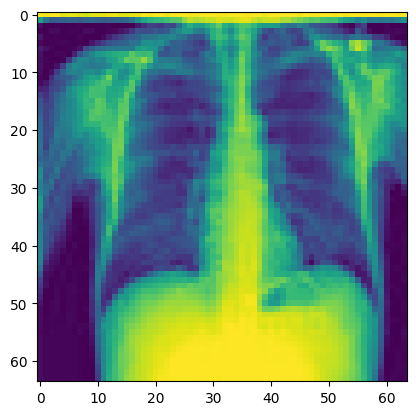

In [ ]:
im = plt.imread('/content/drive/MyDrive/archive_mmnist/CXR/000000.jpeg')
plt.imshow(im)

In [ ]:
im.shape

(64, 64)

In [ ]:
files = glob.glob('/content/drive/MyDrive/archive_mmnist/**/*.jpeg', recursive=True)

In [ ]:
len(files)

32573

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'path': files})

In [ ]:
df.head()

,path
0,/content/drive/MyDrive/archive_mmnist/BreastMR...
1,/content/drive/MyDrive/archive_mmnist/BreastMR...
2,/content/drive/MyDrive/archive_mmnist/BreastMR...
3,/content/drive/MyDrive/archive_mmnist/BreastMR...
4,/content/drive/MyDrive/archive_mmnist/BreastMR...


In [ ]:
df['path'][0]

'/content/drive/MyDrive/archive_mmnist/BreastMRI/005326.jpeg'

In [ ]:
df['class'] = df['path'].apply(lambda x: x.split('/')[5])

In [ ]:
df['class'].value_counts()

BreastMRI    5430
Hand         5430
CXR          5430
AbdomenCT    5430
HeadCT       5429
ChestCT      5424
Name: class, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['path'] , df['class'], test_size = 0.1)

In [ ]:
len(X_train)

29315

In [ ]:
len(X_test)

3258

In [ ]:
def build_model():

    model = Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=2, activation="relu", input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(28, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 28)                861084    
                                                                 
 dense_1 (Dense)             (None, 6)                 174       
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
df_train.head()

,path,class
7843,/content/drive/MyDrive/archive_mmnist/ChestCT/...,ChestCT
22148,/content/drive/MyDrive/archive_mmnist/AbdomenC...,AbdomenCT
30355,/content/drive/MyDrive/archive_mmnist/HeadCT/0...,HeadCT
15520,/content/drive/MyDrive/archive_mmnist/Hand/003...,Hand
21947,/content/drive/MyDrive/archive_mmnist/AbdomenC...,AbdomenCT


In [ ]:
BATCH_SIZE = 128

In [ ]:
train_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='training', color_mode='grayscale')

Found 24918 validated image filenames belonging to 6 classes.


In [ ]:
valid_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='validation', color_mode='grayscale')

Found 4397 validated image filenames belonging to 6 classes.


In [ ]:
checkpoint = ModelCheckpoint('medical_image_model.hdf5',
                             monitor='val_loss',
                             verbose=1, mode='min',
                             save_best_only=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                                   min_delta=0.001,
                                   patience=5,
                                   mode='min',
                                   verbose=1)

In [ ]:
model.fit(train_generator, callbacks=[checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//BATCH_SIZE, epochs=50)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.9414
Epoch 1: val_loss improved from inf to 0.02877, saving model to medical_image_model.hdf5
194/194 [==============================] - 934s 5s/step - loss: 0.1880 - accuracy: 0.9414 - val_loss: 0.0288 - val_accuracy: 0.9956
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9961
Epoch 2: val_loss improved from 0.02877 to 0.01385, saving model to medical_image_model.hdf5
194/194 [==============================] - 108s 557ms/step - loss: 0.0231 - accuracy: 0.9961 - val_loss: 0.0139 - val_accuracy: 0.9968
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980
Epoch 3: val_loss improved from 0.01385 to 0.01149, saving model to medical_image_model.hdf5
194/194 [==============================] - 111s 573ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.0115 - val_accuracy: 0.9975
Epoch 4/50
194/194 [===============

In [ ]:
model

In [ ]:
model = load_model('medical_image_model.hdf5')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
test_imgs = [img_to_array(load_img(im_path, grayscale=True)) for im_path in X_test]

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
y_pred = model.predict(np.array(test_imgs))

102/102 [==============================] - 2s 23ms/step


In [ ]:
y_pred.argmax(axis=1)

array([3, 1, 3, ..., 3, 4, 3])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_test

array(['ChestCT', 'BreastMRI', 'CXR', 'HeadCT', 'AbdomenCT', 'Hand'],
      dtype=object)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
y_test = le.fit_transform(y_test)

In [ ]:
le.classes_

array(['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT'],
      dtype=object)

In [ ]:
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))

In [ ]:
cm

array([[  0,   0,   0, 498,  42,   0],
       [ 19, 416,   3,  89,   2,   9],
       [  0,   0, 548,   1,   7,   0],
       [  0,   0,   0, 531,   0,   0],
       [  0,   0,   8,   5, 532,   0],
       [  0,   0,   2, 224, 322,   0]])

In [ ]:
train_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='training', color_mode='rgb')
valid_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='validation', color_mode='rgb')

Found 24918 validated image filenames belonging to 6 classes.
Found 4397 validated image filenames belonging to 6 classes.


In [ ]:
def build_model2(shape):
    '''
    Constroi as camadas da rede
    :return: modelo construido
    '''

    base_model = MobileNetV2(weights = "imagenet", include_top=False, input_shape = shape)
    # congelando camadas que não iremos treinar.
    # para congelar alguns layers específicos basta passar o indice: for layer in mobile.layers[:5]:
    for layer in base_model.layers[:3]:
        layer.Trainable=False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    predictions = layers.Dense(6, activation='softmax')(x)

    model = Model(base_model.input, predictions)

    return model

In [ ]:
model = build_model2((64,64,3))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
model.fit(train_generator, callbacks=[checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//BATCH_SIZE, epochs=50)

Epoch 1/50
190/194 [============================>.] - ETA: 2:53 - loss: 0.0332 - accuracy: 0.9908